## Import package

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Import

In [4]:
df_train=pd.read_csv("./original_data/mitbih_train.csv")
df_test=pd.read_csv("./original_data/mitbih_test.csv")

In [5]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [6]:
X_train_=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

## Resampling

In [7]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 20000}, random_state=13) 
over_sampler = SMOTETomek(sampling_strategy={1: 20000, 
                                        2: 20000, 
                                        3: 20000, 
                                        4: 20000},random_state=13)

pipeline = Pipeline([
    ('under', under_sampler), 
    ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_, y_train)


In [9]:
label_map = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

class_counts = y_train.value_counts().sort_index()

class_labels = [label_map[i] for i in class_counts.index]

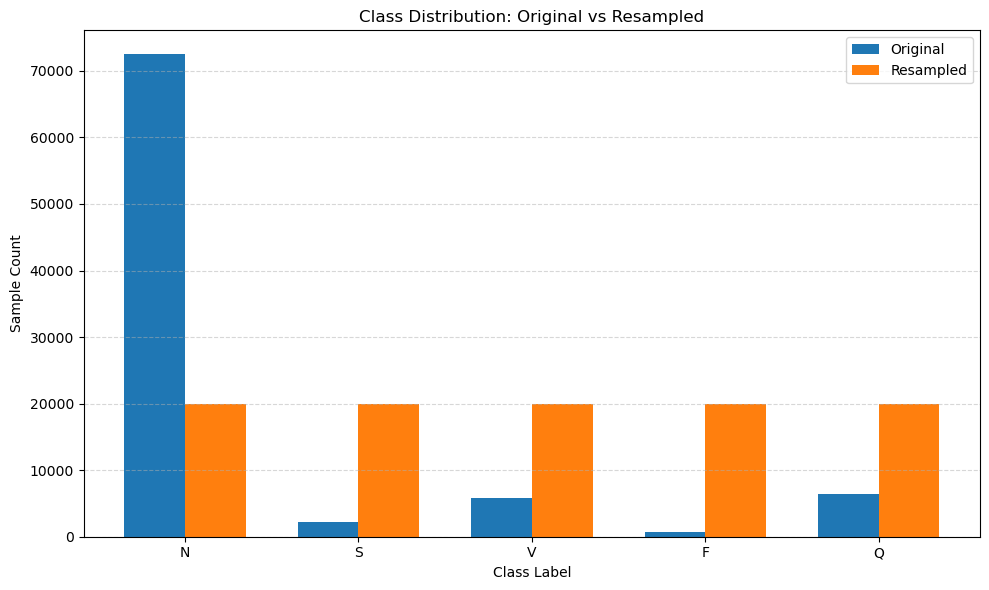

In [10]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, class_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## CNN

In [11]:
# import torch and relative functions

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [12]:
# define model
class ECG_CNN_1D(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
# Modify data and data loader

X_train_tensor = torch.tensor(X_resampled.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_resampled.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [14]:
# parameters of model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_CNN_1D(num_classes=5).to(device)

num_epochs = 30
learning_rate= 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

In [15]:
from sklearn.metrics import recall_score
import numpy as np

def custom_weighted_recall(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4])
    weights = np.array([0.1, 1, 1, 1, 0.5])
    return np.sum(recalls * weights) / np.sum(weights)

# training
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    weighted_recall = custom_weighted_recall(np.array(all_labels), np.array(all_preds))

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, "
          f"Weighted Recall: {weighted_recall:.4f}")

Epoch 1/30, Train Loss: 0.7006, Test Loss: 0.6523, Weighted Recall: 0.8510
Epoch 2/30, Train Loss: 0.3493, Test Loss: 0.5883, Weighted Recall: 0.8867
Epoch 3/30, Train Loss: 0.2749, Test Loss: 0.4428, Weighted Recall: 0.8740
Epoch 4/30, Train Loss: 0.2354, Test Loss: 0.3307, Weighted Recall: 0.8783
Epoch 5/30, Train Loss: 0.2083, Test Loss: 0.3362, Weighted Recall: 0.8912
Epoch 6/30, Train Loss: 0.1904, Test Loss: 0.2886, Weighted Recall: 0.8877
Epoch 7/30, Train Loss: 0.1754, Test Loss: 0.2179, Weighted Recall: 0.8629
Epoch 8/30, Train Loss: 0.1653, Test Loss: 0.2719, Weighted Recall: 0.8809
Epoch 9/30, Train Loss: 0.1576, Test Loss: 0.3226, Weighted Recall: 0.8855
Epoch 10/30, Train Loss: 0.1496, Test Loss: 0.2282, Weighted Recall: 0.8668
Epoch 11/30, Train Loss: 0.1416, Test Loss: 0.1639, Weighted Recall: 0.8431
Epoch 12/30, Train Loss: 0.1362, Test Loss: 0.2888, Weighted Recall: 0.8952
Epoch 13/30, Train Loss: 0.1300, Test Loss: 0.2387, Weighted Recall: 0.8898
Epoch 14/30, Train Lo

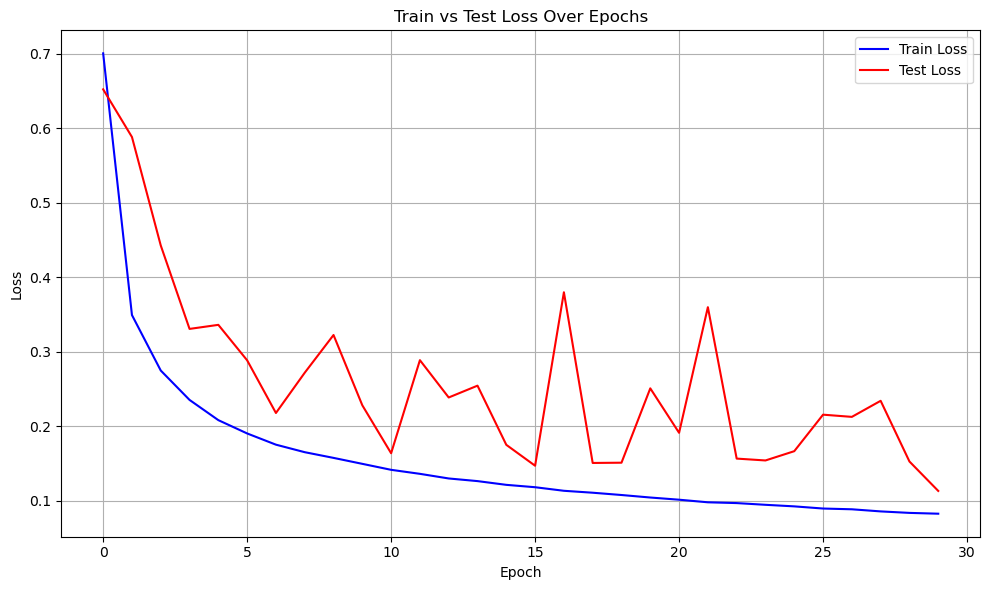

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18117
           1       0.71      0.60      0.65       556
           2       0.93      0.92      0.92      1448
           3       0.51      0.88      0.65       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.97     21891
   macro avg       0.82      0.87      0.84     21891
weighted avg       0.97      0.97      0.97     21891



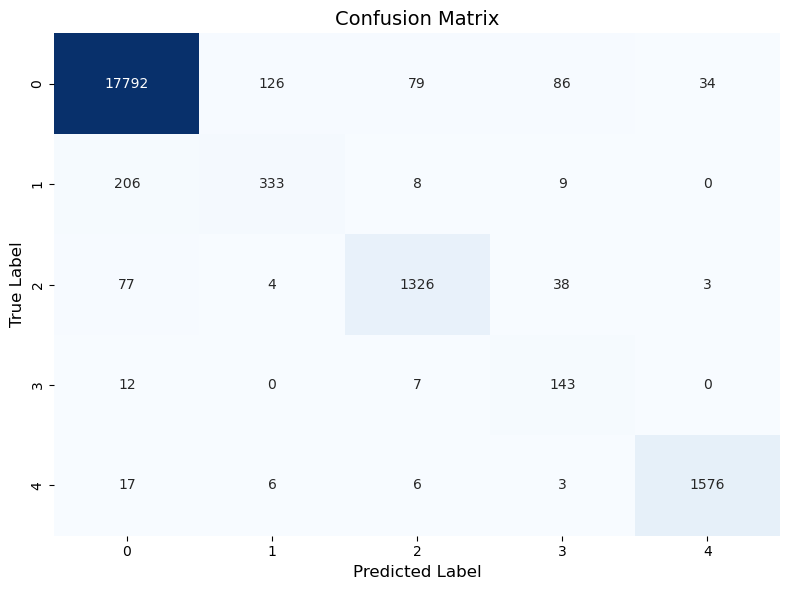

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
torch.save(model.state_dict(), 'cnn_model.pkl')